In [39]:
import os
import torch
import matplotlib.pyplot as plt
import math


from pprint import pprint
from torch.utils.data import DataLoader

In [76]:
from torch.utils.data import Dataset
from PIL import Image
import os

epoch = 4

class MyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.samples = []
                
        for file_name in os.listdir(image_dir):
            if file_name.endswith('.jpg'):
                image_path = os.path.join(image_dir, file_name)
                # mask is in png format
                file_name = file_name.replace('.jpg', '.png')
                mask_path = os.path.join(mask_dir, file_name)
                sample = (image_path, mask_path)
                self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path = self.samples[idx]
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)
                
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [77]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)), # modificar a 512
    transforms.ToTensor(),
])

train_dataset = MyDataset(image_dir='train/portadas', mask_dir='train/mascarasSC', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4) #nm = 4 para linux

# obtengo val_dataset y val_dataloader de train_dataset haciendo un split a 0.9
val_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.1), len(train_dataset) - int(len(train_dataset)*0.1)])
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4) #nm = 4 para linux

test_dataset = MyDataset(image_dir='test/portadas', mask_dir='test/mascarasSC', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4) #nm = 4 para linux

print(len(train_dataset))

3234


In [78]:
# Verifica canles y tamaños
images, masks = next(iter(train_dataloader))

print(images.shape)
print(masks.shape)


torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6441b30ca0>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3/dist-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


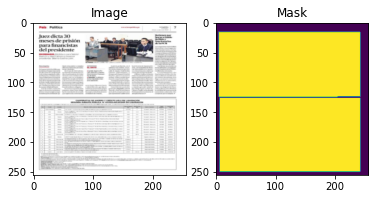

In [79]:
import matplotlib.pyplot as plt

# Get a batch of images and masks
images, masks = next(iter(val_dataloader))

# Plot the first image and mask in the batch
plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0))
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(masks[0].permute(1, 2, 0))
plt.title('Mask')

plt.show()

In [73]:
masks[0][0][125][125]

tensor(0.0078, device='cuda:2')

In [45]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [74]:
print(UNet(11))

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [55]:
# jaccar funcion


import numpy as np
def iou(groundtruth_mask, pred_mask):
    # from cuda to cpu
    groundtruth_mask = groundtruth_mask.detach().cpu().numpy()
    pred_mask = pred_mask.detach().cpu().numpy()
    #print(np.sum(pred_mask))
    #print(np.sum(groundtruth_mask)) 
    
    intersect = np.sum(pred_mask *groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

def iou2(groundtruth_mask, pred_mask):
    # from cuda to cpu
    groundtruth_mask = groundtruth_mask.detach().cpu().numpy()
    pred_mask = pred_mask.detach().cpu().numpy()
        
    intersect = np.sum(np.abs(pred_mask *groundtruth_mask))
    union = np.sum(np.abs(pred_mask)) + np.sum(np.abs(groundtruth_mask)) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

def jaccard_index(masks, outputs):
    smooth = 1e-6
    outputs = outputs.detach().cpu().numpy()
    labels = masks.detach().cpu().numpy()
    #print(np.sum(outputs))
    #print(np.sum(np.abs(outputs)))
    #print(np.sum(labels)) 
    #print(np.sum(np.abs(labels)))
    intersection = np.sum(outputs * labels)
    #print(intersection)
    union = np.sum(outputs) + np.sum(labels) - intersection
    #print(union)
    jac = (intersection + smooth) / (union + smooth)        
    #print(jac)
    return jac.mean()

def jaccard_index2(masks, outputs):
    smooth = 1e-6
    outputs = outputs.detach().cpu().numpy()
    labels = masks.detach().cpu().numpy()
    #print(np.sum(outputs))
    #print(np.sum(np.abs(outputs)))
    #print(np.sum(labels)) 
    #print(np.sum(np.abs(labels)))
    #intersection = np.sum(np.abs(outputs) * np.abs(labels))
    intersection = np.sum(np.abs(outputs*labels))
    #print(intersection)
    union = np.sum(np.abs(outputs) + np.abs(labels)) - intersection
    #print(union)
    jac = (intersection + smooth) / (union + smooth)        
    #print(jac)
    return  (1 - jac) * smooth
    #return jac.mean()


import torch

def jaccard_index3(pred_mask, true_mask):
    intersection = torch.logical_and(pred_mask, true_mask).sum()
    union = torch.logical_or(pred_mask, true_mask).sum()

    jaccard = intersection / union
    return jaccard.item()


In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torchvision.transforms.functional as TF
#from unet import UNet

device = torch.device(f'cuda:{2}' if torch.cuda.is_available() else 'cpu')
print(device)

#model = UNet(in_channels=3).to(device)
model = UNet(11).to(device)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



for epoch in range(epoch):  #epochs
    for i, (images, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{10}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

        # metricas jaccard funcion
        print(f"jaccard_index3: {jaccard_index3(masks, outputs):.4f}")
        print(f"jaccard_index2: {jaccard_index2(masks, outputs):.4f}")
        print(f"iou: {iou(masks, outputs):.4f}")
        print(f"iou2: {iou2(masks, outputs):.4f}")
        print(f"jaccard_index: {jaccard_index(masks, outputs):.4f}")
        

    with torch.no_grad():
        val_loss = 0.0

        for images, masks in val_dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item() * images.size(0)

        val_loss /= len(val_dataloader.dataset)

        print(f"Epoch [{epoch+1}/{10}], Validation Loss: {val_loss:.4f}")
     

torch.save(model.state_dict(), 'model.pth')

test_loss = 0.0

with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        test_loss += loss.item() * images.size(0)

    test_loss /= len(test_dataloader.dataset)

print(f"Test Loss: {test_loss:.4f}")



cuda:2


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/lib/python3/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/lib/python3/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_2649389/1854574930.py", line 38, in __getitem__
    mask = self.transform(mask)
  File "/usr/lib/python3/dist-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/usr/lib/python3/dist-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/torchvision/transforms/transforms.py", line 361, in forward
    return F.resize(img, self.size, self.interpolation, self.max_size, self.antialias)
  File "/usr/lib/python3/dist-packages/torchvision/transforms/functional.py", line 476, in resize
    _, image_height, image_width = get_dimensions(img)
  File "/usr/lib/python3/dist-packages/torchvision/transforms/functional.py", line 78, in get_dimensions
    return F_pil.get_dimensions(img)
  File "/usr/lib/python3/dist-packages/torchvision/transforms/_functional_pil.py", line 31, in get_dimensions
    raise TypeError(f"Unexpected type {type(img)}")
TypeError: Unexpected type <class 'numpy.ndarray'>


torch.Size([3, 256, 256])
(8, 256, 256)


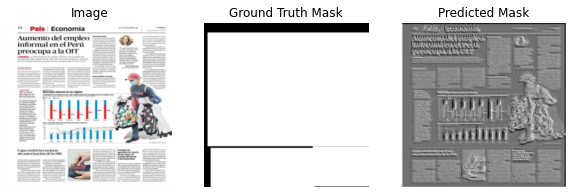

In [58]:
# graficar

model = UNet(11)

# Load weights from the file (.pth usually)
model.load_state_dict(torch.load('model.pth'))
model.eval()

images, masks = next(iter(test_dataloader))
print(images[0].shape)

outputs = model(images)

pred_mask = torch.sigmoid(outputs).squeeze(1).detach().cpu().numpy()

print(pred_mask.shape)

# Plot the real image, ground truth mask, and predicted mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(images[3].permute(1, 2, 0))
plt.axis('off')
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(masks[3].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(pred_mask[3], cmap='gray')
#plt.imshow(outputs[3], cmap='gray')
plt.axis('off')
plt.title('Predicted Mask')

plt.show()

In [59]:
masks[3]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0157],
         [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0157],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]]])

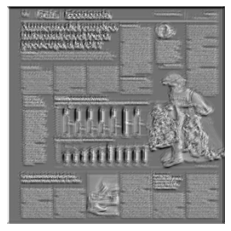

In [60]:
# La grafica de salida, la prediccion 
plt.imshow(pred_mask[3], cmap='gray')
plt.axis('off')
plt.show()


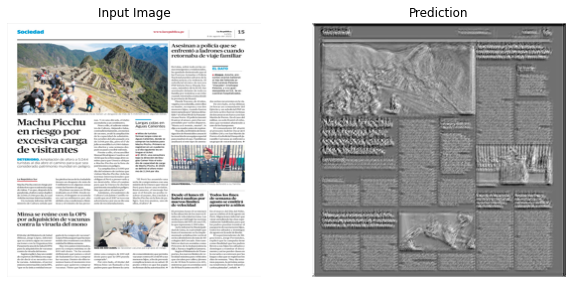

In [61]:
# Para probar el modelo, cargar una imagen y predecir la mascara en pytorch

# Load the trained model from file
model = UNet(1)
model.load_state_dict(torch.load('model.pth'))
model.eval()

# Load the image and convert to grayscale
#image = Image.open('test_image.jpg')

# Cargar la imagen y realizar la preprocesamiento necesario
#image = Image.open('ruta/imagen.jpg').convert('RGB')
image = Image.open('test_image3.jpg')
image = image.resize((256, 256))
image = np.array(image).astype(np.float32) / 255.0
image = np.transpose(image, (2, 0, 1))  # Cambiar el orden de las dimensiones
image = torch.from_numpy(image).unsqueeze(0)

# Realizar la predicción utilizando el modelo
with torch.no_grad():
    prediction = model(image)
    prediction = torch.sigmoid(prediction)  # Aplicar una función de activación si es necesario

# Convertir el resultado de la predicción a un array NumPy y quitar la dimensión de lote
prediction = prediction.squeeze(0).squeeze(0).detach().numpy()

# Mostrar la imagen de entrada y la predicción
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(prediction, cmap='gray')
plt.axis('off')
plt.title('Prediction')

plt.show()


In [62]:
prediction.shape

(256, 256)

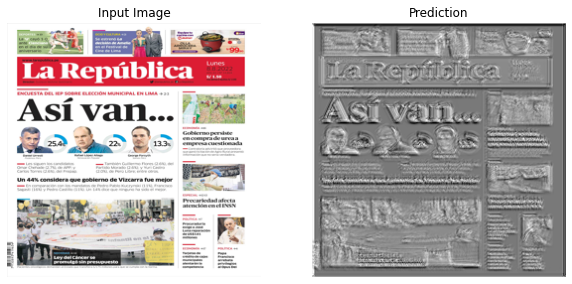

In [63]:
# Para probar el modelo, cargar una imagen y predecir la mascara en pytorch

# Load the trained model from file
model = UNet(1)
model.load_state_dict(torch.load('model.pth'))
model.eval()

# Load the image and convert to grayscale
#image = Image.open('test_image.jpg')

# Cargar la imagen y realizar la preprocesamiento necesario
#image = Image.open('ruta/imagen.jpg').convert('RGB')
image = Image.open('test_image4.jpg')
image = image.resize((256, 256))
image = np.array(image).astype(np.float32) / 255.0
image = np.transpose(image, (2, 0, 1))  # Cambiar el orden de las dimensiones
image = torch.from_numpy(image).unsqueeze(0)

# Realizar la predicción utilizando el modelo
with torch.no_grad():
    prediction = model(image)
    prediction = torch.sigmoid(prediction)  # Aplicar una función de activación si es necesario

# Convertir el resultado de la predicción a un array NumPy y quitar la dimensión de lote
prediction = prediction.squeeze(0).squeeze(0).detach().numpy()

# Mostrar la imagen de entrada y la predicción
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(prediction, cmap='gray')
plt.axis('off')
plt.title('Prediction')

plt.show()

In [64]:
pred_mask

array([[[0.4721329 , 0.47201505, 0.47146258, ..., 0.47141752,
         0.47122034, 0.47141927],
        [0.47244805, 0.47155017, 0.4706011 , ..., 0.4701043 ,
         0.47001955, 0.470616  ],
        [0.47299585, 0.47219178, 0.4708305 , ..., 0.47025374,
         0.47069782, 0.47074902],
        ...,
        [0.47302642, 0.47275627, 0.4715848 , ..., 0.47051445,
         0.47098953, 0.47060576],
        [0.47237307, 0.4719642 , 0.47183546, ..., 0.4707115 ,
         0.47080788, 0.47121525],
        [0.4722739 , 0.4722804 , 0.47213012, ..., 0.47172505,
         0.47148386, 0.47138622]],

       [[0.4721329 , 0.47201505, 0.47146258, ..., 0.47141752,
         0.47122034, 0.47141927],
        [0.47244805, 0.47155017, 0.47060105, ..., 0.47010425,
         0.4700195 , 0.470616  ],
        [0.4729959 , 0.47219178, 0.4708305 , ..., 0.47025374,
         0.47069776, 0.47074905],
        ...,
        [0.47302642, 0.47275627, 0.4715848 , ..., 0.47051486,
         0.47098994, 0.47060588],
        [0.4

In [65]:
import cv2
import numpy as np

# Obtener los contornos de la segmentación
contours, _ = cv2.findContours(prediction.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Verificar si se encontraron contornos
if len(contours) > 0:
    # Calcular el rectángulo delimitador de la segmentación
    x, y, w, h = cv2.boundingRect(contours[0])

    # Mostrar el largo y ancho de la segmentación
    print("Largo: ", h)
    print("Ancho: ", w)
else:
    print("No se encontraron contornos en la segmentación.")

No se encontraron contornos en la segmentación.
